In [1]:
import os
import random
from collections import defaultdict
from math import sqrt, pi, e
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import plotly.express as px
from prophet import Prophet
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import eli5
from xgboost import XGBRegressor, plot_tree

plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4), titlesize=18, titleweight='bold')
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlesize=16, titlepad=10)
%config InlineBackend.figure_format = 'retina'

In [2]:
"""
    Helper - moves column at specified order
"""

def move_column(df, column, t_ind):
    cols = list(df.columns)
    i = cols.index(column)
    cols = cols[:t_ind] + cols[i:i + 1] + cols[t_ind:i] + cols[i + 1:]
    return df[cols]

In [3]:
"""
    Load data
"""

informative_rows = ['Quarters', 'INCOME STATEMENT', 'Revenue', 'Operating Income', 
                    'Gross Profit', 'Pretax Income', 'Income (Loss) from Cont Ops', 'Net Income', 
                    'Net Income Avail to Common', 'Diluted EPS', 'EBITDA', 'Total Equity', 
                    'Cash from Operations', 'Cash from Investing Activities', 'Cash from Financing Activities']
set_rows = set(informative_rows)
dataframes = {}

files = os.listdir('oil_gas_train')[:-1]
print(files)

for file in files:
    # Load data
    df = pd.read_excel('oil_gas_train/' + file)
    data = df.to_numpy()
    data = data[26:, 8:]
    data[0, 0] = 'Quarters'

    # remove empty columns
    revenue_i = -1
    for i, s in enumerate(data[:, 0]):
        if s == 'Revenue':
            revenue_i = i

    start_j = 1
    for j in range(len(data[revenue_i])):
        if data[revenue_i][j] == 0:
            start_j = j + 1
    
    # crate dataframe
    data = np.concatenate((data[:, 0:1], data[:, start_j:]), axis = 1)
    st = {data[i, 0]: data[i, 1:] for i, s in enumerate(data[:, 0]) if s in set_rows}
    df = pd.DataFrame(st)
    df[informative_rows[2:]] = df[informative_rows[2:]].apply(pd.to_numeric)
    
    dataframes[file] = df

['AMPY.xlsx', 'APA.xlsx', 'AR.xlsx', 'BATL.xlsx', 'BCEI.xlsx', 'BRY.xlsx', 'BSM.xlsx', 'CDEV.xlsx', 'CHK.xlsx', 'CLR.xlsx', 'CNX.xlsx', 'COG.xlsx', 'COP.xlsx', 'CPE.xlsx', 'CRBO.xlsx', 'CRC.xlsx', 'CRK.xlsx', 'DEN.xlsx', 'DVN.xlsx', 'EGY.xlsx', 'EOG.xlsx', 'EQT.xlsx', 'ESTE.xlsx', 'FANG.xlsx', 'GDP.xlsx', 'HES.xlsx', 'LONE.xlsx', 'LPI.xlsx', 'MCF.xlsx', 'MGY.xlsx', 'MNRL.xlsx', 'MRO.xlsx', 'MTDR.xlsx', 'MUR.xlsx', 'NOG.xlsx', 'OAS.xlsx', 'OVV.xlsx', 'PDCE.xlsx', 'PVAC.xlsx', 'PXD.xlsx', 'REI.xlsx', 'RRC.xlsx', 'SBOW.xlsx', 'SD.xlsx', 'SM.xlsx', 'SWN.xlsx', 'TALO.xlsx', 'TPL.xlsx', 'VNOM.xlsx', 'WLL.xlsx', 'WTI.xlsx', 'XEC.xlsx', 'XOG.xlsx']


In [4]:
"""
    For each company we create
    1) seasonal features
    2) add dummy time stamp
    3) prepare lags for selected features and target variables
"""

def prepare_dataframe(df, file):
    # Adding seasonal features
    df['q1'] = df['Quarters'].str.contains('Q1', regex=False).astype(int)
    df['q2'] = df['Quarters'].str.contains('Q2', regex=False).astype(int)
    df['q3'] = df['Quarters'].str.contains('Q3', regex=False).astype(int)
    
    # We add time-step feature, which is dummy variable indicating time
    df['Time'] = np.arange(len(df.index))

    # We will not have access to informative rows at present time
    # Thus we need to take lag and drop them
    informative_features = informative_rows[4:]
    for ir in informative_features:
        df['lag1_' + ir] = df[ir].shift(1).fillna(0.0)
    df = df.drop(columns=informative_features)    
    
    # We make lag-1, lag-2, lag-3, lag-4 features. Shifted Revenue and Operating Income
    for i in range(1, 5):
        df['lag%d_' % i + 'Revenue'] = df['Revenue'].shift(i).fillna(0.0)
        df['lag%d_' % i + 'Operating Income'] = df['Operating Income'].shift(i).fillna(0.0)
        
    # Remember the company name
    df['Company'] = file[:-5]
    df = move_column(df, 'Company', 0)
    
    # drop first columns, because lag_1, lag_2 features are very important and first rows doesnt have them
    df = df.iloc[2:]
    
    return df

In [5]:
"""
    We create combined dataset with all companies
"""

prepared_data = []
for file, df in dataframes.items():
    pr_df = prepare_dataframe(df, file)
    prepared_data.append(pr_df)
    
comb_df = pd.concat(prepared_data, ignore_index=True)

print('Shape of full data - %d rows, %d columns' % comb_df.shape)
comb_df.sample(10)

Shape of full data - 1702 rows, 28 columns


,Company,Quarters,INCOME STATEMENT,Revenue,Operating Income,q1,q2,q3,Time,lag1_Gross Profit,...,lag1_Cash from Investing Activities,lag1_Cash from Financing Activities,lag1_Revenue,lag1_Operating Income,lag2_Revenue,lag2_Operating Income,lag3_Revenue,lag3_Operating Income,lag4_Revenue,lag4_Operating Income
1167,PDCE,Q4 '11 A,2011-12-31,103.383000,16.213000,0,0,0,3,33.476000,...,-180.420992,172.087008,95.870000,18.658000,88.217000,1.799000,79.643000,1.251000,0.000000,0.000000
410,CPE,Q3 '15 A,2015-09-30,44.105000,13.277000,0,0,1,18,16.959000,...,-60.013000,36.039000,44.207000,11.426000,40.734000,5.877000,45.487000,14.297000,39.195000,11.200000
429,CPE,Q2 '20 A,2020-06-30,157.234000,-77.091000,0,1,0,37,86.393008,...,-254.366000,64.130000,289.919008,63.690000,192.742000,83.321000,156.388992,59.485000,165.895008,57.373000
1299,REI,Q4 '19 A,2019-12-31,52.231184,17.922018,0,0,0,27,18.202448,...,-36.093752,5.937390,50.339104,14.342410,51.334224,17.636416,41.798316,10.235485,23.008432,-0.367937
1062,NOG,Q3 '12 A,2012-09-30,82.404080,28.627768,0,0,1,6,29.814096,...,-138.934528,113.323296,69.408288,25.394488,59.887904,24.192072,50.588984,23.492156,41.944640,18.865622
823,HES,Q4 '13 A,2013-12-31,2721.999872,592.000000,0,0,0,11,2345.000000,...,-1487.000064,-171.000000,2720.000000,775.000000,3068.999936,1052.000000,6105.999872,1135.000064,5718.000128,695.000000
644,EOG,Q3 '13 A,2013-09-30,3805.964032,1038.063168,0,0,1,10,2123.447040,...,-1726.891008,-39.321000,3704.451072,959.391552,3364.286976,840.846976,3156.401920,787.025984,3131.973888,782.865984
171,BRY,Q1 '19 A,2019-03-31,76.539000,-35.509000,1,0,0,4,194.735984,...,-39.065000,-14.305000,280.345984,172.648000,142.947008,58.825000,65.982000,-23.001000,97.284000,-0.745000
30,AMPY,Q4 '19 A,2019-12-31,77.929000,8.399000,0,0,0,32,24.365000,...,66.005000,-102.327000,72.959000,-0.696000,59.532000,4.076000,65.155000,4.692000,75.702000,17.310000
1579,WLL,Q4 '11 A,2011-12-31,493.456992,216.748992,0,0,0,3,235.414000,...,-420.267008,139.730000,470.444000,201.976992,476.256000,222.032992,428.745984,185.283008,0.000000,0.000000


In [6]:
"""
    Train model
    Print predictions on test data
    
    Get coefficient of determination metric, MAX is 1:
    1 - sum((y_true - y_pred) ** 2) / sum((y_true - y_true.mean()) ** 2)
"""

features = comb_df.columns[5:]
targets = ['Revenue', 'Operating Income']
predicted = ['lin_pr_' + t for t in targets]
predicted_tree = ['tree_pr_' + t for t in targets]

X_train, X_test, y_train, y_test = train_test_split(comb_df[features], comb_df[targets], random_state=42)
pipe = make_pipeline(StandardScaler(), LinearRegression())

pipe.fit(X_train, y_train)
comb_df[predicted] = pipe.predict(comb_df[features])

for i, t in enumerate(targets):
    comb_df = move_column(comb_df, 'lin_pr_' + t, 4 + 2 * i)

print('Coefficient of determination:', pipe.score(X_test, y_test))
comb_df.loc[X_test.index].head(10)


Coefficient of determination: 0.6854937173589692


,Company,Quarters,INCOME STATEMENT,Revenue,lin_pr_Revenue,Operating Income,lin_pr_Operating Income,q1,q2,q3,...,lag1_Cash from Investing Activities,lag1_Cash from Financing Activities,lag1_Revenue,lag1_Operating Income,lag2_Revenue,lag2_Operating Income,lag3_Revenue,lag3_Operating Income,lag4_Revenue,lag4_Operating Income
705,EQT,Q4 '19 A,2019-12-31,948.355968,991.715002,-386.183008,24.142963,0,0,0,...,-491.580992,149.932000,943.307008,-27.064000,960.529984,5.612000,1213.971968,258.344000,1231.453056,4.051000
809,GDP,Q2 '19 A,2019-06-30,31.884000,-3.770846,4.352000,3.108198,0,1,0,...,-26.970000,4.995000,29.140000,5.107000,33.907000,11.642000,24.420000,5.023000,17.835000,2.087000
1432,SM,Q1 '17 A,2017-03-31,335.275008,408.815499,13.924000,-14.956394,1,0,0,...,-1508.820992,399.735008,346.239008,-37.271000,330.272000,-46.462000,291.768000,-117.206000,212.096992,-199.836000
173,BRY,Q3 '19 A,2019-09-30,194.672000,220.041014,81.883000,105.606430,0,0,1,...,-61.594000,-16.223000,170.066000,64.142000,76.539000,-35.509000,280.345984,172.648000,142.947008,58.825000
513,CRK,Q4 '16 A,2016-12-31,48.498000,-0.168064,-3.032000,-60.825109,0,0,0,...,-7.488000,-9.826000,50.330000,-85.480000,40.715000,-19.317000,36.163000,-26.712000,47.228000,-35.577000
1649,WTI,Q2 '20 A,2020-06-30,77.819000,78.349778,9.951000,10.925767,0,1,0,...,-35.647000,-33.536000,133.520000,19.291000,151.287008,35.715000,132.404000,29.729000,132.667000,33.540000
818,HES,Q3 '12 A,2012-09-30,3072.000000,3689.187047,880.000000,1175.439934,0,0,1,...,-1992.999936,766.000000,3324.000000,1228.999936,2896.000000,906.000000,9749.000192,820.000000,8714.999808,654.000000
261,CLR,Q2 '14 A,2014-06-30,886.094976,859.691457,313.575008,369.792366,0,1,0,...,-1019.480000,351.871008,972.494976,488.023008,811.219968,332.278016,823.835008,369.984992,1100.752000,654.633024
405,CPE,Q2 '14 A,2014-06-30,38.856000,42.717281,10.564000,26.320503,0,1,0,...,-63.534000,42.297000,32.410000,5.883000,27.161000,4.861000,30.163000,5.711000,23.453000,1.650000
1399,SD,Q4 '17 A,2017-12-31,93.206000,88.057597,15.130385,-6.506746,0,0,0,...,-58.826000,-0.875000,80.892000,-3.552000,108.394000,27.610616,98.350000,22.135000,98.456000,25.845000


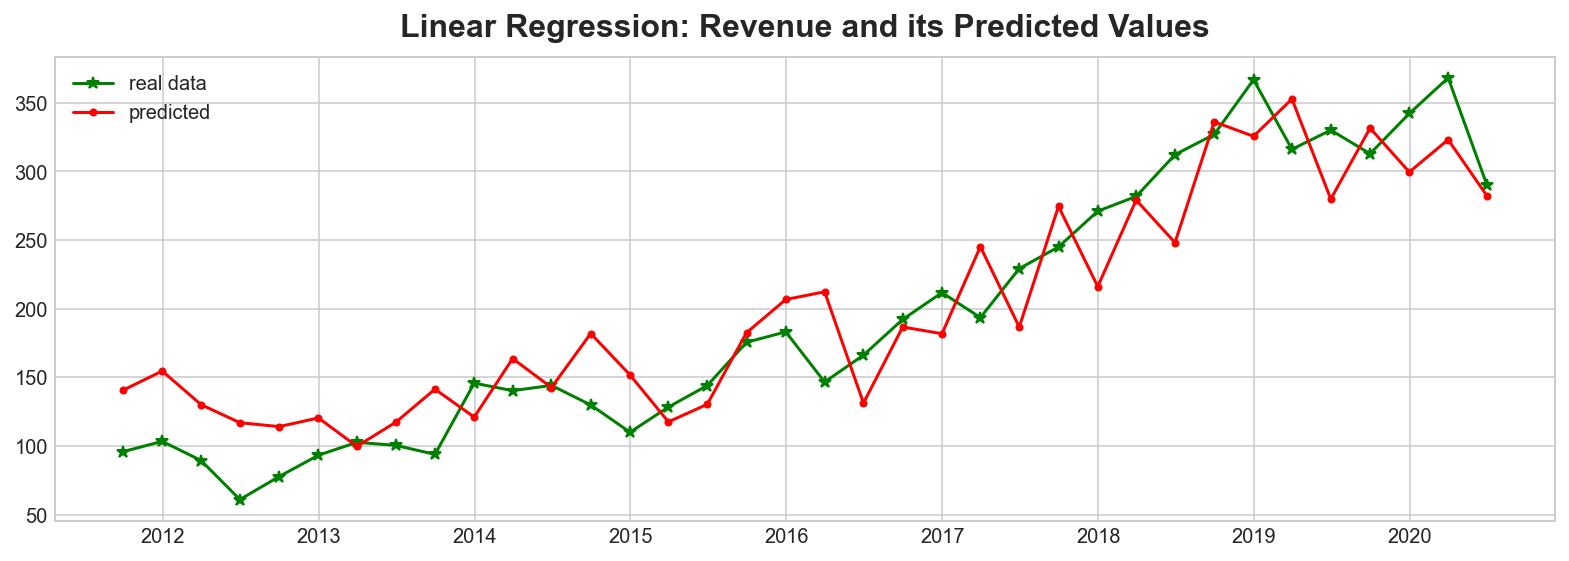

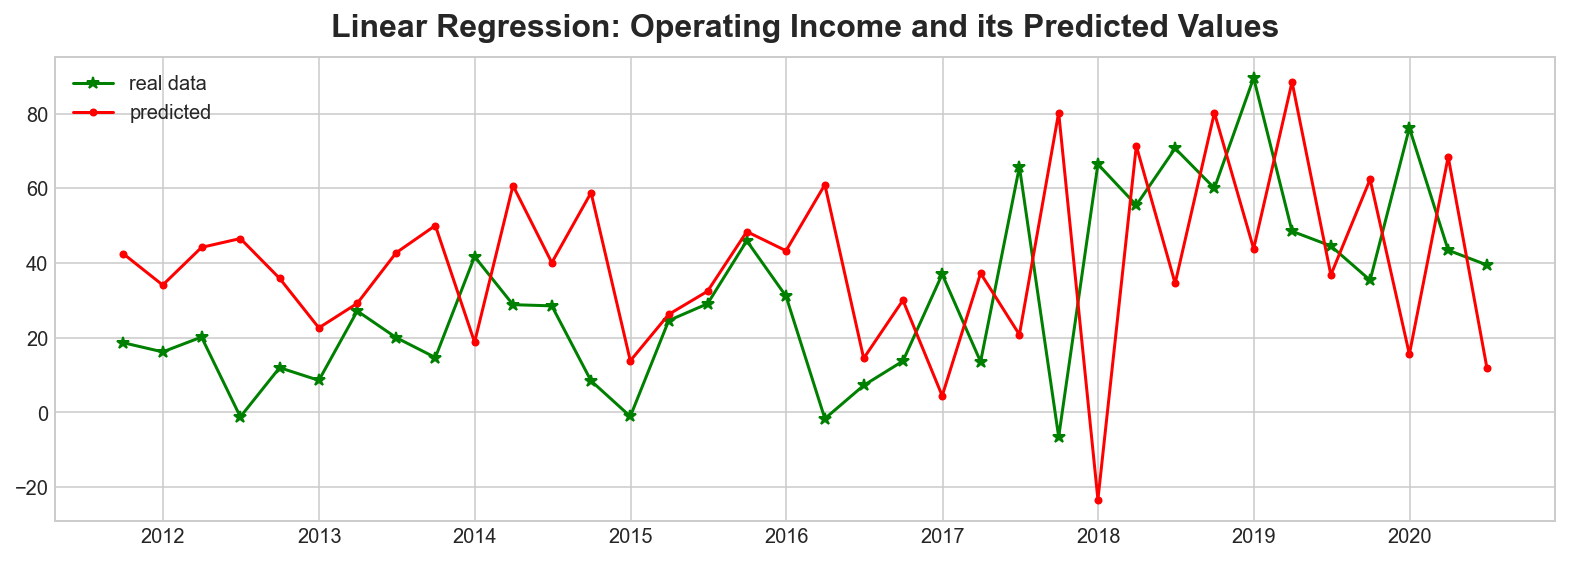

In [7]:
"""
    Visualize predictions on PDCE company
"""

pdce_df = comb_df.loc[comb_df['Company'] == 'PDCE']

for t in targets:
    fig, ax = plt.subplots()
    ax.plot('INCOME STATEMENT', t, data=pdce_df, color='g', marker='*', label='real data')
    ax.plot('INCOME STATEMENT', 'lin_pr_' + t, data=pdce_df, color='r', marker='.', label='predicted')

    plt.legend()
    ax.set_title('Linear Regression: %s and its Predicted Values' % t);

In [8]:
"""
    Visualize weights of a linear regression
"""

eli5.show_weights(pipe.named_steps['linearregression'], target_names = targets, feature_names = X_train.columns.tolist())

Revenue top features,Operating Income top features
Weight?,Feature
+1507.343,lag1_Revenue
+949.115,lag1_Net Income
+857.306,<BIAS>
+253.819,lag1_EBITDA
+205.205,lag1_Pretax Income
+75.298,lag4_Revenue
+52.582,lag2_Revenue
+47.881,lag1_Income (Loss) from Cont Ops
+45.725,lag3_Operating Income


In [9]:
"""
    Train decision trees
"""

xgb = XGBRegressor()
xgb.fit(X_train, y_train)

comb_df[predicted_tree] = xgb.predict(comb_df[features])
for i, t in enumerate(targets):
    comb_df = move_column(comb_df, 'tree_pr_' + t, 5 + 3 * i)

print('Coefficient of determination:', xgb.score(X_test, y_test))
comb_df.sample(5)

Coefficient of determination: 0.8327422357033789


,Company,Quarters,INCOME STATEMENT,Revenue,lin_pr_Revenue,tree_pr_Revenue,Operating Income,lin_pr_Operating Income,tree_pr_Operating Income,q1,...,lag1_Cash from Investing Activities,lag1_Cash from Financing Activities,lag1_Revenue,lag1_Operating Income,lag2_Revenue,lag2_Operating Income,lag3_Revenue,lag3_Operating Income,lag4_Revenue,lag4_Operating Income
443,CRBO,Q4 '13 A,2013-12-31,5.360000,40.252318,4.226755,1.635000,6.619746,0.094690,0,...,-2.799000,0.394,4.949000,1.449000,5.045000,1.703000,3.284000,0.153,3.925000,-0.026000
233,CHK,Q2 '16 A,2016-06-30,2166.000128,1939.083573,2164.488037,-115.000000,-55.258278,-114.376427,0,...,-273.000000,-115.000,1995.000064,11.615385,2700.000000,-19.538462,3443.000064,161.000,3822.000128,221.000000
1052,MUR,Q1 '19 A,2019-03-31,629.353984,501.439964,626.163940,126.108864,56.344154,124.952209,1,...,-957.468032,259.638,503.448000,66.451872,473.235008,93.522072,389.143008,22.042,366.827008,8.855253
995,MTDR,Q4 '13 A,2013-12-31,69.274000,126.490000,77.968719,23.760000,40.590404,24.170252,0,...,-84.183000,42.128,80.703000,33.967000,58.433000,19.187000,59.711000,11.800,55.561000,9.433000
297,CNX,Q2 '14 A,2014-06-30,865.976000,899.788523,975.001953,43.373000,127.496333,173.937515,0,...,-335.480992,-13.954,910.430016,122.387000,776.204032,20.839000,762.659968,39.221,769.608000,36.555000


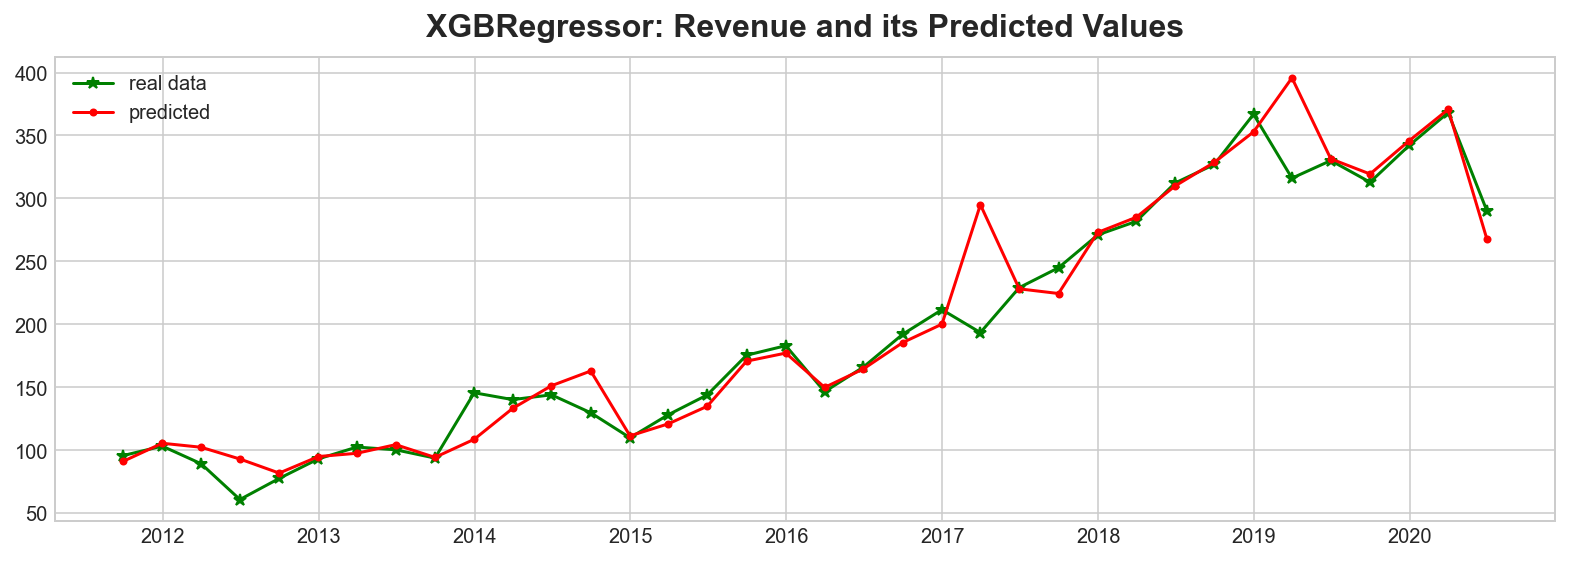

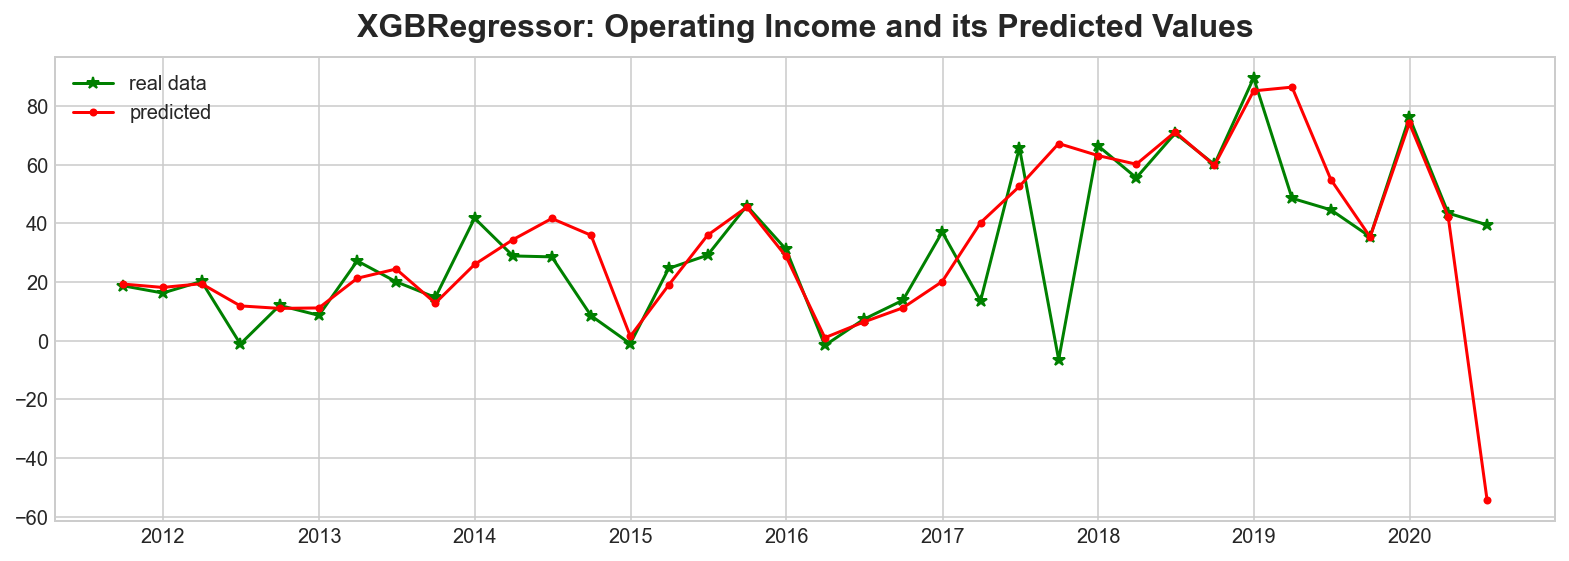

In [10]:
"""
    Visualize predictions on PDCE company with XGBRegressor
"""

pdce_df = comb_df.loc[comb_df['Company'] == 'PDCE']

for t in targets:
    fig, ax = plt.subplots()
    ax.plot('INCOME STATEMENT', t, data=pdce_df, color='g', marker='*', label='real data')
    ax.plot('INCOME STATEMENT', 'tree_pr_' + t, data=pdce_df, color='r', marker='.', label='predicted')

    plt.legend()
    ax.set_title('XGBRegressor: %s and its Predicted Values' % t);

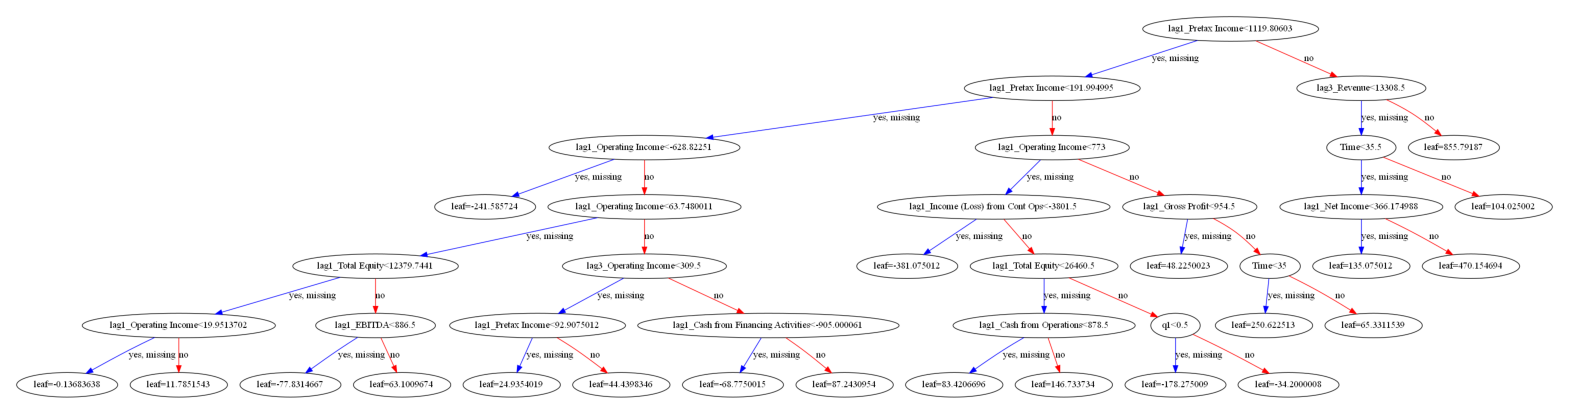

In [15]:
"""
    Попытка визуализировать дерево
"""

fig, ax = plt.subplots()
plot_tree(xgb, num_trees=1, ax=ax)
plt.show()

#### Заключение

Мы смогли загрузить все данные в один датафрейм. Построили модель линейной регрессии и XGBRegressor, над этими данными. Мы визуализировали коеффициенты линейной регрессии. А также построили плот одной компаний и посмотрели как выглядят наши предсказания.

Мы видим некоторое улучшение XGB регрессора над линейным. Coefficient of determination поднялся с 0.68 до 0.83.